In [2]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [3]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [4]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [5]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(quantum_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [6]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [7]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

SRMRoc_offset = []
max_offset = .5 #50cm Roc change in SRM curvature
steps = 5

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset
    SRMRoc_offset.append(dRc)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SRMHR_Rc_new = SRMHR_Rc_orig + dRc
    kat1.SRMHR.Rcx.value = SRMHR_Rc_new
    kat1.SRMHR.Rcy.value = SRMHR_Rc_new

    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
    SRCTL_q1_x = out_new_SRM_roc["SRCoutx"]
    SRCTL_q1_y = out_new_SRM_roc["SRCouty"]
    SRMY_q1_x = out_new_SRM_roc["SRMYqx"]
    SRMY_q1_y = out_new_SRM_roc["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)

    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)

    #### Turn off all the cav commands except XARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)

    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))


    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True

    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)


    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [8]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI
darm_list = []
freq = []
kat_list = []
out_list = []

SRCTL_q3_x_list = []
SRCTL_q3_y_list = []

SRMY_q3_x_list =[]
SRMY_q3_y_list =[]

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(darm_commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(quantum_detectors)
    basekat3.parseCommands("maxtem "+str(2))
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("""
    bp sqz_qx x q nsqz
    bp sqz_qy y q nsqz
    """)
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SRMHR_Rc = kat.SRMHR.Rc
    dRc = SRMRoc_offset[i]
    
    kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
    kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    out3 = kat3.run()

    SRCTL_q3_x = out3["SRCoutx"]
    SRCTL_q3_y = out3["SRCouty"]

    SRMY_q3_x = out3["SRMYqx"]
    SRMY_q3_y = out3["SRMYqy"]


    SRCTL_q3_x_list.append(SRCTL_q3_x)
    SRMY_q3_x_list.append(SRMY_q3_x)

    freq.append(out3.x)
    darm_list.append(out3['NSR_with_RP'])
    kat_list.append(kat3)
    out_list.append(out3)


Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [9]:
#### Get overlaps in the final state

f_overlap_SRC_to_ARM_x = []
f_overlap_SRC_to_ARM_y = []

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

f_overlap_OMC_to_SRC_x = []
f_overlap_OMC_to_SRC_y = []

f1_list = []
f2_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
f_q_BS_SRCY_x = []
f_q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
f_q_BS_ITMY_x = []
f_q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
f_q_BS_OMC_x = []
f_q_BS_OMC_y = []

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("maxtem "+str(2))
    basekat3.parseCommands(add_squeezing)
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SRMHR_Rc = kat.SRMHR.Rc
    dRc = SRMRoc_offset[i]

    kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
    kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

        #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')
    f_q_BS_SRCY_x.append(srcx)
    f_q_BS_SRCY_y.append(srcy)


    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')
    f_q_BS_ITMY_x.append(ARMx)
    f_q_BS_ITMY_y.append(ARMy)


    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')
    f_q_BS_OMC_x.append(OMCx)
    f_q_BS_OMC_y.append(OMCy)


    f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    f_overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    f_overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    f_overlap_OMC_to_SRC_x.append(pykat.beam_param.overlap(OMCx,srcx))
    f_overlap_OMC_to_SRC_y.append(pykat.beam_param.overlap(OMCy,srcy))

    f1_list.append(f1)
    f2_list.append(f2) 

Removed existing object 'sqz' of type <class 'pykat.components.pykat.components.squeezer_2991'> to add line 'sq sqz 0 10 0 nsqz'
Successfully Mode-Matched! >99.9% overlap
f1 is 0.3696317498932183
f2 is -0.36950886580337755
Removed existing object 'sqz' of type <class 'pykat.components.pykat.components.squeezer_3252'> to add line 'sq sqz 0 10 0 nsqz'
Successfully Mode-Matched! >99.9% overlap
f1 is -0.5244020611323619
f2 is 0.5249339558495397
Removed existing object 'sqz' of type <class 'pykat.components.pykat.components.squeezer_3513'> to add line 'sq sqz 0 10 0 nsqz'
Successfully Mode-Matched! >99.9% overlap
f1 is -0.1494396738948437
f2 is 0.14960722058466536
Removed existing object 'sqz' of type <class 'pykat.components.pykat.components.squeezer_3774'> to add line 'sq sqz 0 10 0 nsqz'
Successfully Mode-Matched! >99.9% overlap
f1 is -0.08577326992065325
f2 is 0.08590662894495198
Removed existing object 'sqz' of type <class 'pykat.components.pykat.components.squeezer_4035'> to add line 

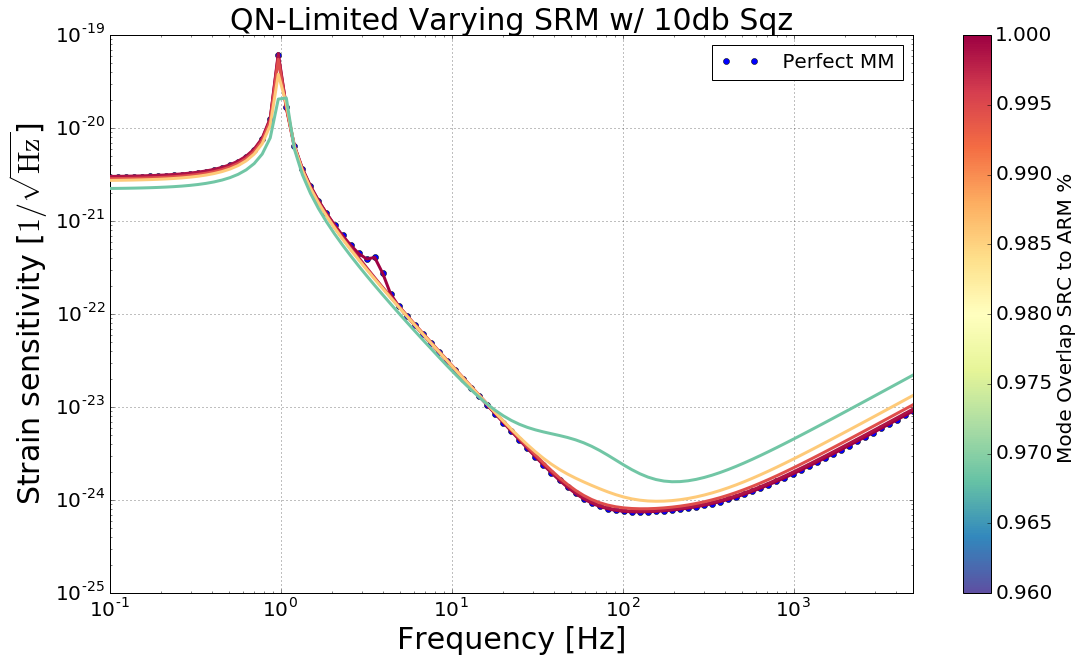

In [10]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.96, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(overlap_SRC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("QN-Limited Varying SRM w/ 10db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
#pl.ylim(3e-25,1e-22)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

###Colorbar formatting
cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap SRC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=20) 
cb.update_ticks()

pl.savefig("ht_varyingSRM_w10dbSqz.eps")

pl.show()

In [11]:
f_overlap_OMC_to_ARM_x

[1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002]

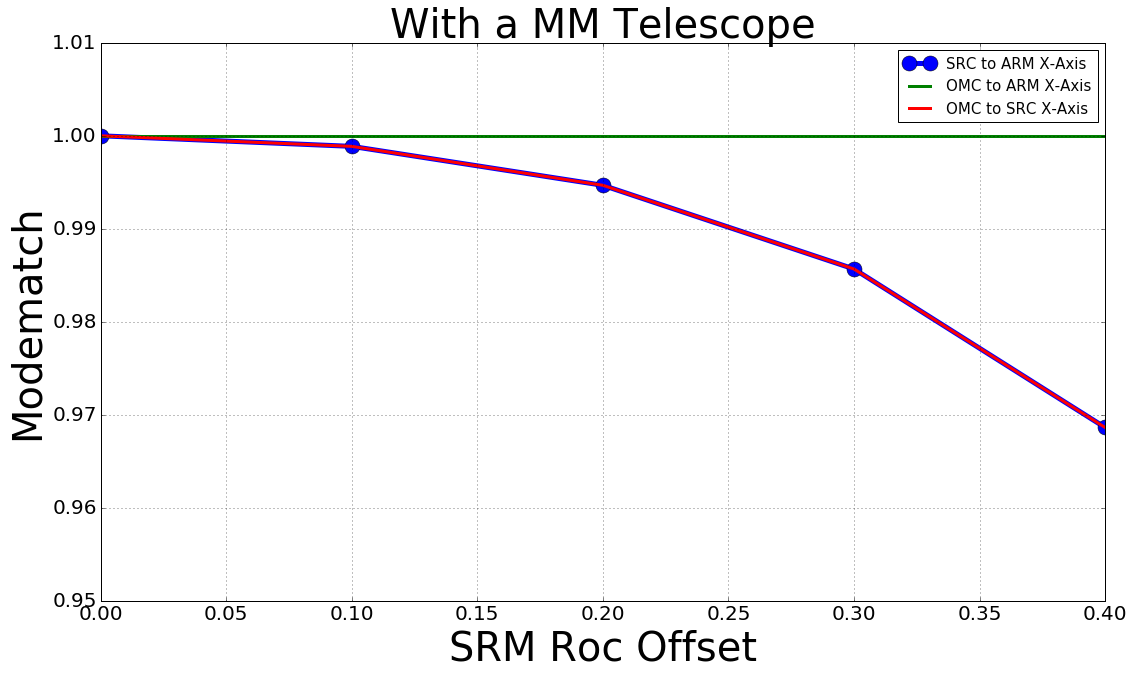

In [12]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("With a MM Telescope",fontsize=40)

pl.plot(SRMRoc_offset, f_overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=5, label='SRC to ARM X-Axis')
pl.plot(SRMRoc_offset, f_overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')
pl.plot(SRMRoc_offset, f_overlap_OMC_to_SRC_x,linewidth=3, label='OMC to SRC X-Axis')


pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(SRMRoc_offset),max(SRMRoc_offset))
pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SRM Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("MMvsSRMoffset_w_MMTT_10dbSqz.eps")

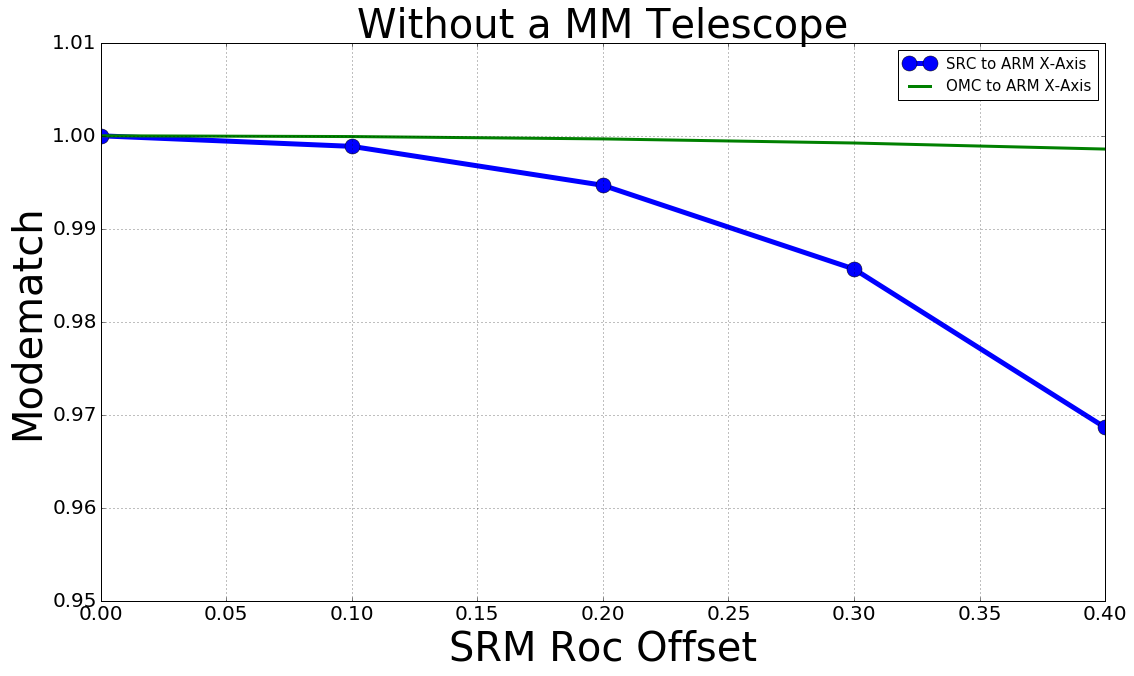

In [13]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("Without a MM Telescope",fontsize=40)

pl.plot(SRMRoc_offset, overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=5, label='SRC to ARM X-Axis')
pl.plot(SRMRoc_offset, overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')

pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(SRMRoc_offset),max(SRMRoc_offset))
pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SRM Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("MMvsSRMoffset_wo_MMTT_10dbSqz.eps")

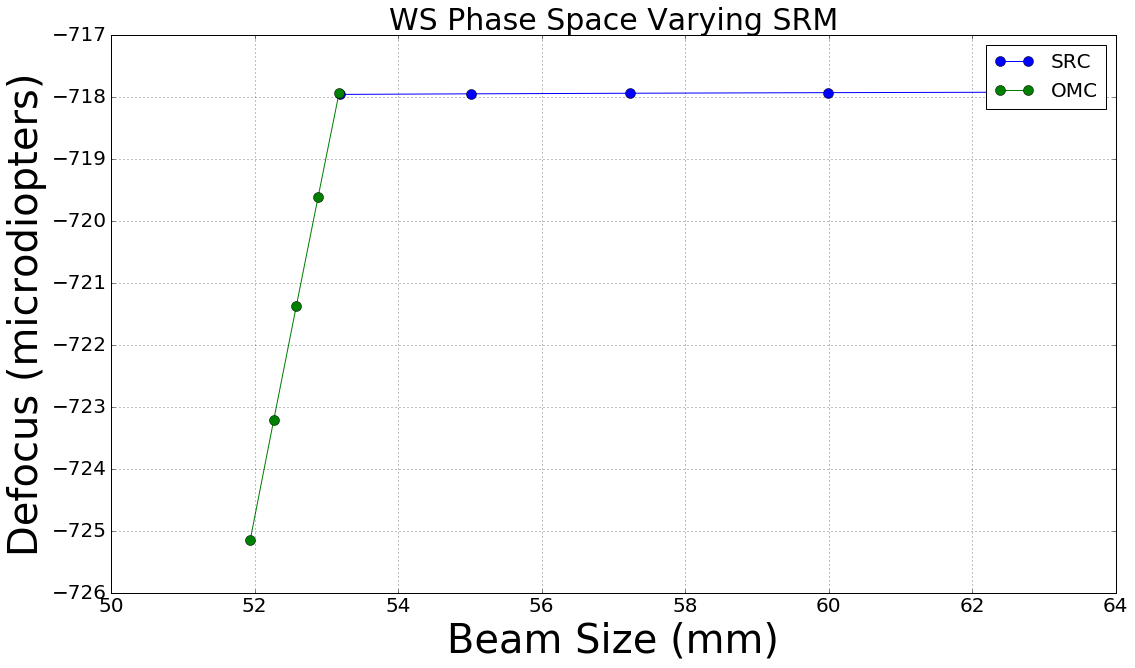

In [14]:
### beamsize is in mm and defocus is in microdipoters (no MM)
SRC_wx, SRC_wy, SRC_sx, SRC_sy = get_WS.phase_space(q_BS_SRCY_x,q_BS_SRCY_y)
OMC_wx, OMC_wy, OMC_sx, OMC_sy = get_WS.phase_space(q_BS_OMC_x,q_BS_OMC_y)

### beamsize is in mm and defocus is in microdipoters (w/ MM)
f_SRC_wx, f_SRC_wy, f_SRC_sx, f_SRC_sy = get_WS.phase_space(f_q_BS_SRCY_x,f_q_BS_SRCY_y)
f_OMC_wx, f_OMC_wy, f_OMC_sx, f_OMC_sy = get_WS.phase_space(f_q_BS_OMC_x,f_q_BS_OMC_y)

pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.title("WS Phase Space Varying SRM",fontsize=30)
pl.plot(SRC_wx,SRC_sx,'-o', markersize = 10,label='SRC')
pl.plot(OMC_wx,OMC_sx,'-o', markersize = 10,label='OMC')

pl.legend(fontsize=20)

pl.ticklabel_format(useOffset=False)
pl.xlabel("Beam Size (mm)",fontsize=40)
pl.ylabel("Defocus (microdiopters)",fontsize=40)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.grid()

pl.savefig("WSPhaseSpaceVarySRM_OMC_SRC_noSqz_wMM.png")
pl.show()

In [16]:
###This half of the code is for trying to figure out the mode-referencing for the squeezer

katfile_swpFC = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified_swpFC.kat"

basekat4 = pykat.finesse.kat() 
basekat4.loadKatFile(katfile_swpFC)
basekat4.parseCommands(darm_commands)
basekat4.parseCommands(amplitude_detectors)
basekat4.parseCommands(quantum_detectors)
basekat4.parseCommands(pds)
basekat4.parseCommands(add_squeezing)
basekat4.parseCommands("maxtem "+str(2))
basekat4.parseCommands(add_squeezing)
basekat4.parseCommands("""
bp sqz_qx x q nsqz
bp sqz_qy y q nsqz
""")

basekat4.undumpNodes()
kat4=basekat4.deepcopy()
kat4.verbose = False

SRMHR_Rc = kat.SRMHR.Rc

#kat4.SRMHR.T.value = 1.0
#kat4.SRMHR.R.value = 0.0
#kat4.SRMHR.L.value = 0.0

kat4.SRMHR.Rcx.value = SRMHR_Rc + SRMRoc_offset[-1]
kat4.SRMHR.Rcy.value = SRMHR_Rc + SRMRoc_offset[-1]


#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[-1]
q2 = q_refout_x_list[-1]
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat4.lSRMTT1.L.value = d1
kat4.SRMTT1.f.value = f1
kat4.lSRMTT2.L.value = d2
kat4.SRMTT2.f.value = f2
kat4.lIBAin.L.value = d3

#kat4.IMFC.R.value = .9999
#kat4.IMFC.T.value = 1-kat4.IMFC.R.value 

kat4.IMFC.L.value = 0

out4 = kat4.run()
freq_swpFC = out4.x
darm_swpFC= out4['NSR_with_RP']

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [17]:
kat_trace_data = kat.run(getTraceData=True) #Orginal, Perfect MM
kat_trace_data3 = kat3.run(getTraceData=True) #Not Bumpy, Bad MM
kat_trace_data4 = kat4.run(getTraceData=True) #Bumpy, Bad MM from FC Swp

In [18]:
####This has the SRM, and ARM matched well, but the Sqzing node is mismatched

katfile_sqz = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified_swpFC.kat"

basekat5 = pykat.finesse.kat() 
basekat5.loadKatFile(katfile_sqz)
basekat5.parseCommands(darm_commands)
basekat5.parseCommands(amplitude_detectors)
basekat5.parseCommands(quantum_detectors)
basekat5.parseCommands(pds)
basekat5.parseCommands(add_squeezing)
basekat5.parseCommands("maxtem "+str(2))
basekat5.parseCommands(add_squeezing)
basekat5.parseCommands("""
bp sqz_qx x q nsqz
bp sqz_qy y q nsqz
""")

sqz_qx = kat_trace_data4[1][0]['nsqz'][0]
sqz_qy = kat_trace_data4[1][0]['nsqz'][1]

sqz_gauss_cmd = 'gauss sqzgauss lsqz_FC nsqz '+ \
str(sqz_qx.w0) + ' ' + str(sqz_qx.z) + ' ' +\
str(sqz_qy.w0) + ' ' + str(sqz_qy.z)


basekat5.parseCommands(sqz_gauss_cmd)

basekat5.undumpNodes()
kat5=basekat5.deepcopy()
kat5.verbose = False

"""kat5.IMFC.R.value = 1
kat5.IMFC.T.value = 0
kat5.IMFC.L.value = 0"""

out5 = kat5.run()
freq_sqz_mismatch = out5.x
darm_sqz_mismatch= out5['NSR_with_RP']

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [19]:
kat_trace_data5 = kat5.run(getTraceData=True) #Sqzer mismatched, everything else matched well.

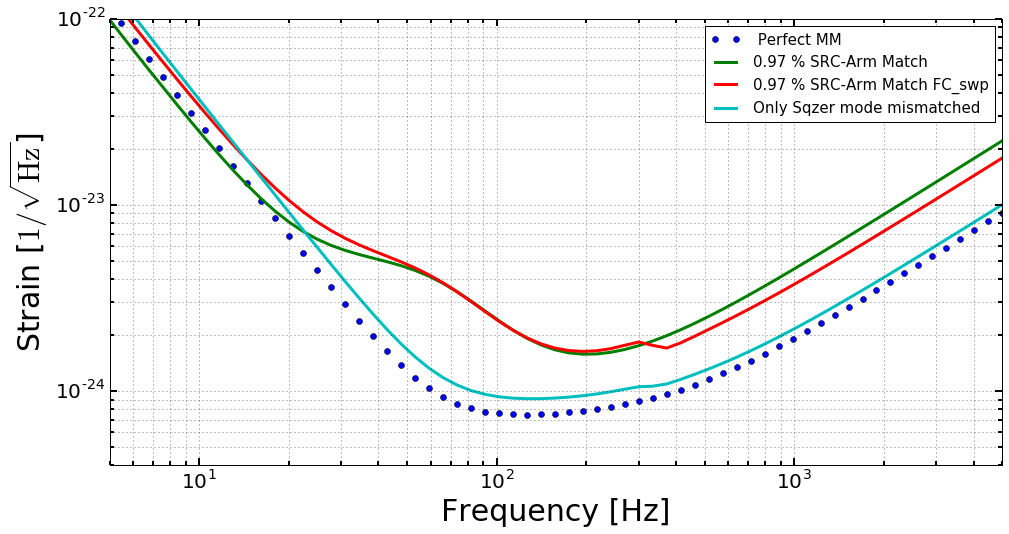

In [20]:
pl.figure(figsize=(16, 8), dpi=80)

pl.subplot(111)
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')
pl.loglog(freq_swpFC, np.real(darm_list[-1]),linewidth=3, 
          label=str(round(overlap_SRC_to_ARM_x[-1],2))+' % SRC-Arm Match')
pl.loglog(freq_swpFC, np.real(darm_swpFC),linewidth=3, 
          label= str(round(overlap_SRC_to_ARM_x[-1],2))+' % SRC-Arm Match FC_swp')
pl.loglog(freq_sqz_mismatch, np.real(darm_sqz_mismatch),linewidth=3,
         label='Only Sqzer mode mismatched')

#pl.xlim(freq[0].min(),freq[0].max())
pl.xlim(5,5000)
pl.ylim(4e-25,1e-22)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which ='both')
pl.legend(fontsize=15)

In [21]:
'''overlap30_list = []
overlap40_list = []
overlap34_list = []

overlap30_avg = []
overlap40_avg = []
overlap34_avg = []

for key in kat_trace_data[1][0]:
    q0 = kat_trace_data[1][0][key][0]._gauss_param__q
    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q
    overlap30 = pykat.beam_param.overlap(q0,q3)
    if round(overlap30,1) < 1.0:
        overlap30_list.append([key,overlap30])
        overlap30_avg.append(overlap30)
        
for key in kat_trace_data[1][0]:
    q0 = kat_trace_data[1][0][key][0]._gauss_param__q
    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q
    overlap40 = pykat.beam_param.overlap(q0,q4)
    if round(overlap40,1) < 1.0:
        overlap40_list.append([key,overlap40])
        overlap40_avg.append(overlap40)
        
for key in kat_trace_data[1][0]:
    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q
    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q
    overlap34 = pykat.beam_param.overlap(q3,q4)
    if round(overlap34,1) < 1.0:
        overlap34_list.append([key,overlap34])
        overlap34_avg.append(overlap34)

avg_30 = sum(overlap30_avg)/len(overlap30_avg)
avg_40 = sum(overlap40_avg)/len(overlap40_avg)
avg_34 = sum(overlap34_avg)/len(overlap34_avg)

print(avg_30,avg_40,avg_34)'''

'overlap30_list = []\noverlap40_list = []\noverlap34_list = []\n\noverlap30_avg = []\noverlap40_avg = []\noverlap34_avg = []\n\nfor key in kat_trace_data[1][0]:\n    q0 = kat_trace_data[1][0][key][0]._gauss_param__q\n    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q\n    overlap30 = pykat.beam_param.overlap(q0,q3)\n    if round(overlap30,1) < 1.0:\n        overlap30_list.append([key,overlap30])\n        overlap30_avg.append(overlap30)\n        \nfor key in kat_trace_data[1][0]:\n    q0 = kat_trace_data[1][0][key][0]._gauss_param__q\n    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q\n    overlap40 = pykat.beam_param.overlap(q0,q4)\n    if round(overlap40,1) < 1.0:\n        overlap40_list.append([key,overlap40])\n        overlap40_avg.append(overlap40)\n        \nfor key in kat_trace_data[1][0]:\n    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q\n    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q\n    overlap34 = pykat.beam_param.overlap(q3,q4)\n    if round(overlap3

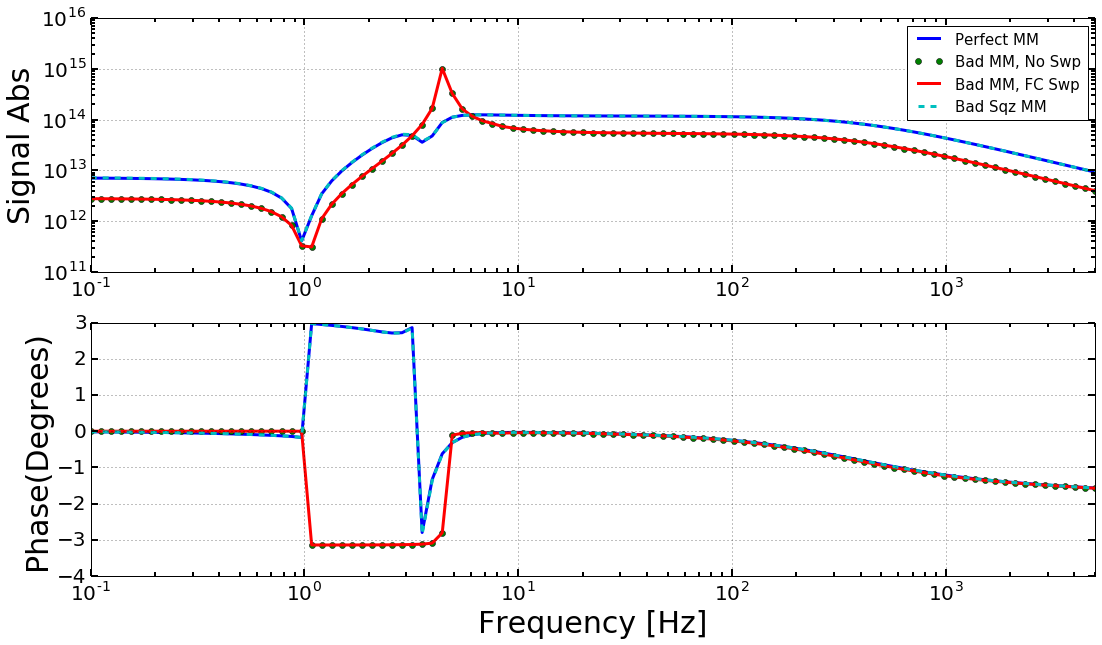

In [22]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['signal']),linewidth=3, label='Perfect MM')
pl.loglog(freq[0], np.absolute(out_list[-1]['signal']),'o',linewidth=3, label='Bad MM, No Swp')
pl.loglog(freq[0], np.absolute(out4['signal']),linewidth=3, label='Bad MM, FC Swp')
pl.loglog(freq[0], np.absolute(out5['signal']),'--',linewidth=3, label='Bad Sqz MM')


###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.ylabel("Signal Abs",fontsize=30)
pl.legend(fontsize=15)


pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['signal']),linewidth=3, label='Perfect MM')
pl.semilogx(freq[0], np.angle(out_list[-1]['signal']),'o',linewidth=3, label='Bad MM, No Swp')
pl.semilogx(freq[0], np.angle(out4['signal']),linewidth=3, label='Bad MM, FC Swp')
pl.semilogx(freq[0], np.angle(out5['signal']),'--',linewidth=3, label='Bad Sqz MM')

pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Phase(Degrees)",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

pl.show()

In [23]:
[srcx,srcy] = trace_mode.from_cav_to_BS(kat5,'cavSRY')

[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat5,'cavXARM')

[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat5,'cavOMC')



print(pykat.beam_param.overlap(srcx,ARMx))
print(pykat.beam_param.overlap(srcy,ARMy))

print(pykat.beam_param.overlap(OMCx,ARMx))
print(pykat.beam_param.overlap(OMCy,ARMy))

print(pykat.beam_param.overlap(OMCx,srcx))
print(pykat.beam_param.overlap(OMCy,srcy))


0.9999999978510681
0.9970292046622555
0.9999999156282784
0.9982612954091425
0.9999999326320355
0.9947168350722998


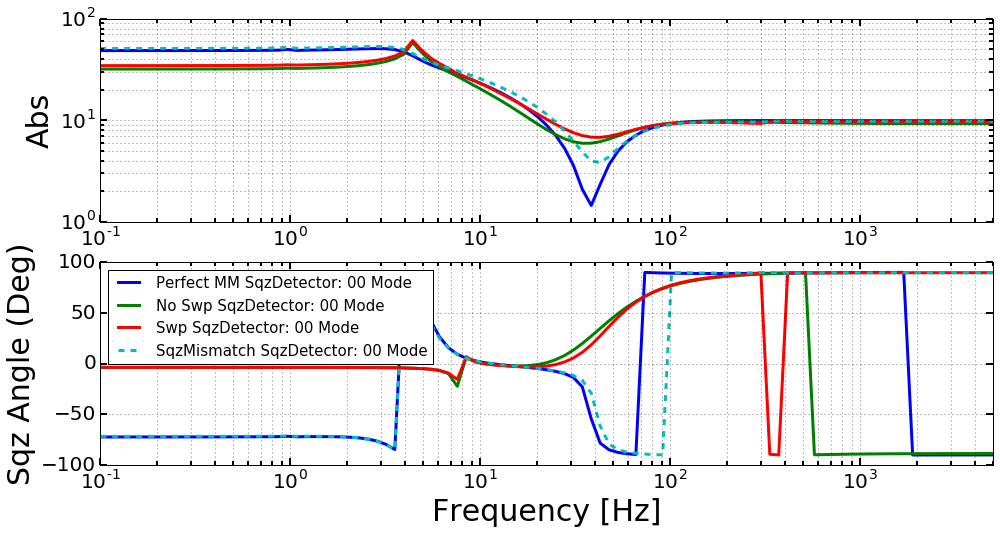

In [24]:
pl.figure(figsize=(16, 8), dpi=80)

pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['sd00']),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
#pl.loglog(freq[0], np.absolute(out_perfect_mm['sd02']),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out_list[-1]['sd00']),linewidth=3, label='No Swp SqzDetector: 00 Mode')
#pl.loglog(freq[0], np.absolute(out_list[-1]['sd02']),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out4['sd00']),linewidth=3, label='Swp SqzDetector: 00 Mode')
#pl.loglog(freq[0], np.absolute(out4['sd02']),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out5['sd00']),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
#pl.loglog(freq[0], np.absolute(out5['sd02']),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')


pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd00'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
#pl.semilogx(freq[0], np.angle(out_perfect_mm['sd02'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out_list[-1]['sd00'],deg=True),linewidth=3, label='No Swp SqzDetector: 00 Mode')
#pl.semilogx(freq[0], np.angle(out_list[-1]['sd02'],deg=True),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out4['sd00'],deg=True),linewidth=3, label='Swp SqzDetector: 00 Mode')
#pl.semilogx(freq[0], np.angle(out4['sd02'],deg=True),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out5['sd00'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
#pl.semilogx(freq[0], np.angle(out5['sd02'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Sqz Angle (Deg)",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')
pl.legend(fontsize=15, loc=2)

pl.show()

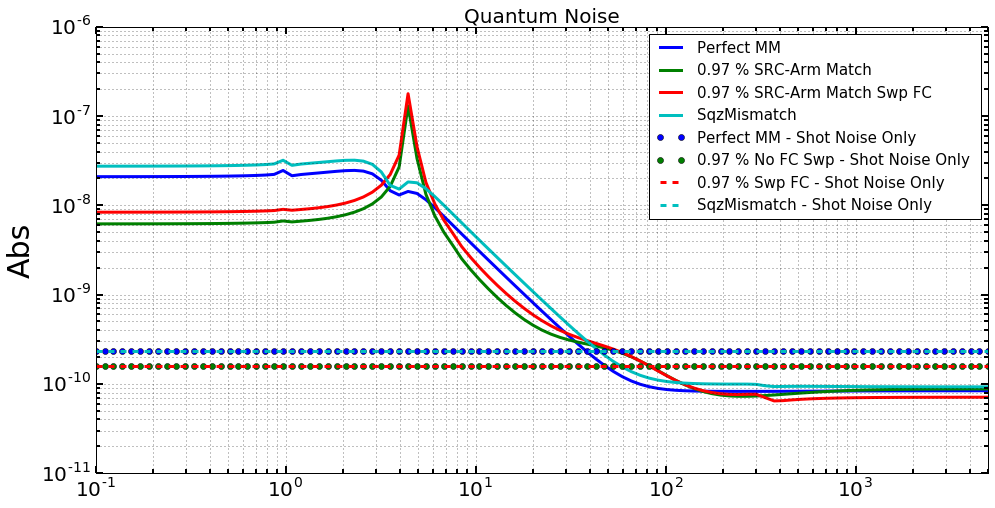

In [25]:
pl.figure(figsize=(16, 8), dpi=80)

pl.subplot(111)

pl.title('Quantum Noise',fontsize=20)

pl.loglog(freq[0], np.absolute(out_perfect_mm['PDquantumnoise']),linewidth=3,
          label='Perfect MM')
pl.loglog(freq[0], np.absolute(out_list[-1]['PDquantumnoise']),linewidth=3,
          label=str(round(overlap_SRC_to_ARM_x[-1],2))+' % SRC-Arm Match ')
pl.loglog(freq[0], np.absolute(out4['PDquantumnoise']),linewidth=3,
          label=str(round(overlap_SRC_to_ARM_x[-1],2))+' % SRC-Arm Match Swp FC')
pl.loglog(freq[0], np.absolute(out5['PDquantumnoise']),linewidth=3,
          label='SqzMismatch')

pl.loglog(freq[0], np.absolute(out_perfect_mm['PDshotnoise']),'o',linewidth=3,
          label='Perfect MM - Shot Noise Only', color ='b')
pl.loglog(freq[0], np.absolute(out_list[-1]['PDshotnoise']),'o',linewidth=3,
          label=str(round(overlap_SRC_to_ARM_x[-1],2))+' % No FC Swp - Shot Noise Only ', color ='g')
pl.loglog(freq[0], np.absolute(out4['PDshotnoise']),'--',linewidth=3,
          label=str(round(overlap_SRC_to_ARM_x[-1],2))+' % Swp FC - Shot Noise Only', color ='r')
pl.loglog(freq[0], np.absolute(out5['PDshotnoise']),'--',linewidth=3,
          label='SqzMismatch - Shot Noise Only', color ='c')



pl.xlim(freq[0].min(),freq[0].max())

pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')
pl.legend(fontsize=15, loc=1)

In [26]:
# Take the node and trace to each caviy for the two ifos, swp and no swp for the FC
# 

node = 'nsqz'

qx_test_node3 = kat_trace_data3[1][0][node][0]._gauss_param__q
qy_test_node3 = kat_trace_data3[1][0][node][1]._gauss_param__q

for cav in kat3.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat3,cav.name,node)
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node3)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node3)
    print(cav.name,qx, round(overlap_x,2), round(overlap_y,2))

cavYARM (8.04126594128007+8.0060965860572j) 1.0 1.0
cavSRX (9.98972044281475+10.7081189823496j) 0.97 0.9
cavPRY (7.96873568494457+7.87841485659124j) 1.0 1.0
cavSRY (9.99095133651159+10.7085902979301j) 0.97 0.9
cavOMC (8.04105597511452+8.00635426537706j) 1.0 1.0
cavXARM (8.04105597511453+8.00635426537716j) 1.0 1.0
cavPRX (7.9683588975285+7.87835557065468j) 1.0 1.0
cavIMC (8.23499131766779+7.99117628082677j) 1.0 1.0
cavFC (8.00000000541322+7.99949998437436j) 1.0 1.0


In [27]:
### Bumps

qx_test_node4 = kat_trace_data4[1][0][node][0]._gauss_param__q
qy_test_node4 = kat_trace_data4[1][0][node][1]._gauss_param__q

for cav in kat4.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat4,cav.name,node)
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node4)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node4)
    print(cav.name,qx, round(overlap_x,2), round(overlap_y,2))

cavYARM (8.04126594128007+8.0060965860572j) 0.97 0.9
cavFC (8.00000000541322+7.99949998437436j) 0.97 0.9
cavSRX (9.98972044281475+10.7081189823496j) 1.0 1.0
cavPRY (7.96873568494457+7.87841485659124j) 0.97 0.91
cavSRY (9.99095133651159+10.7085902979301j) 1.0 1.0
cavOMC (8.04105597511452+8.00635426537706j) 0.97 0.9
cavXARM (8.04105597511453+8.00635426537716j) 0.97 0.9
cavPRX (7.9683588975285+7.87835557065468j) 0.97 0.91
cavIMC (8.23499131766779+7.99117628082677j) 0.97 0.91


In [28]:
qx_test_node5 = kat_trace_data5[1][0][node][0]._gauss_param__q
qy_test_node5 = kat_trace_data5[1][0][node][1]._gauss_param__q

for cav in kat.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat,cav.name,node)
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node5)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node5)
    print(cav.name,qx, round(overlap_x,2), round(overlap_y,2))

cavYARM (8.0448199504002+8.00909817992866j) 0.97 0.9
cavFC (8.00000000541322+7.99949998437436j) 0.97 0.9
cavSRX (8.0440782953313+8.00843040271148j) 0.97 0.93
cavPRY (7.97222013199822+7.88139240298283j) 0.97 0.91
cavSRY (8.0445432085806+8.00861649683913j) 0.97 0.93
cavOMC (8.04105597511452+8.00635426537706j) 0.97 0.9
cavXARM (8.0446099915073+8.00935602590294j) 0.97 0.9
cavPRX (7.97184318273103+7.88133321836008j) 0.97 0.91
cavIMC (8.23861219047375+7.99410776240479j) 0.97 0.91
